In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import utils
from importlib import reload
from torchinfo import summary

In [24]:
# CNN 前半部分のレイヤー関数の確認
conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU()
conv2 = nn.Conv2d(32, 32, 3)
maxpool1 = nn.MaxPool2d(2, 2)

In [25]:
print(conv1)

print(conv1.weight.shape)
print(conv1.bias.shape)

print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [26]:
# 畳み込み処理とプーリング処理のシミュレーション
inputs = torch.rand(100, 3, 32, 32)
print(inputs.shape)

# CNNの前半部分のシミュレーション
x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool1(x4)

print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


In [27]:
# Sequentialを使ったCNNの前半部分のシミュレーション
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool1
)

outputs = features(inputs)
print(outputs.shape)

torch.Size([100, 32, 14, 14])


In [28]:
# flatten()の確認
flatten = nn.Flatten()

outputs2 = flatten(outputs)

print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


In [29]:
# Transforms の定義
# 1つ目は全結合層用なので，flatten() で1次元に変換する
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1))
])

# 2つ目はCNN用
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [30]:
# データセット
data_root = '../data'

train_set1 = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform1
)

test_set1 = datasets.CIFAR10(
    root=data_root,
    train=False,
    download=True,
    transform=transform1
)

train_set2 = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform2
)

test_set2 = datasets.CIFAR10(
    root=data_root,
    train=False,
    download=False,
    transform=transform2
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [31]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]
print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [32]:
# データローダ
# ミニバッチ
batch_size = 100

# 訓練データ
# 訓練データにはシャッフルを行う
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# テストデータ
test_loader1 = DataLoader(test_set1, batch_size=batch_size, shuffle=False)

# 訓練データ
# 訓練データにはシャッフルを行う
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# テストデータ
test_loader2 = DataLoader(test_set2, batch_size=batch_size, shuffle=False)

In [33]:
for image1, label1 in train_loader1:
    break

for image2, label2 in train_loader2:
    break

print(image1.shape)
print(image2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


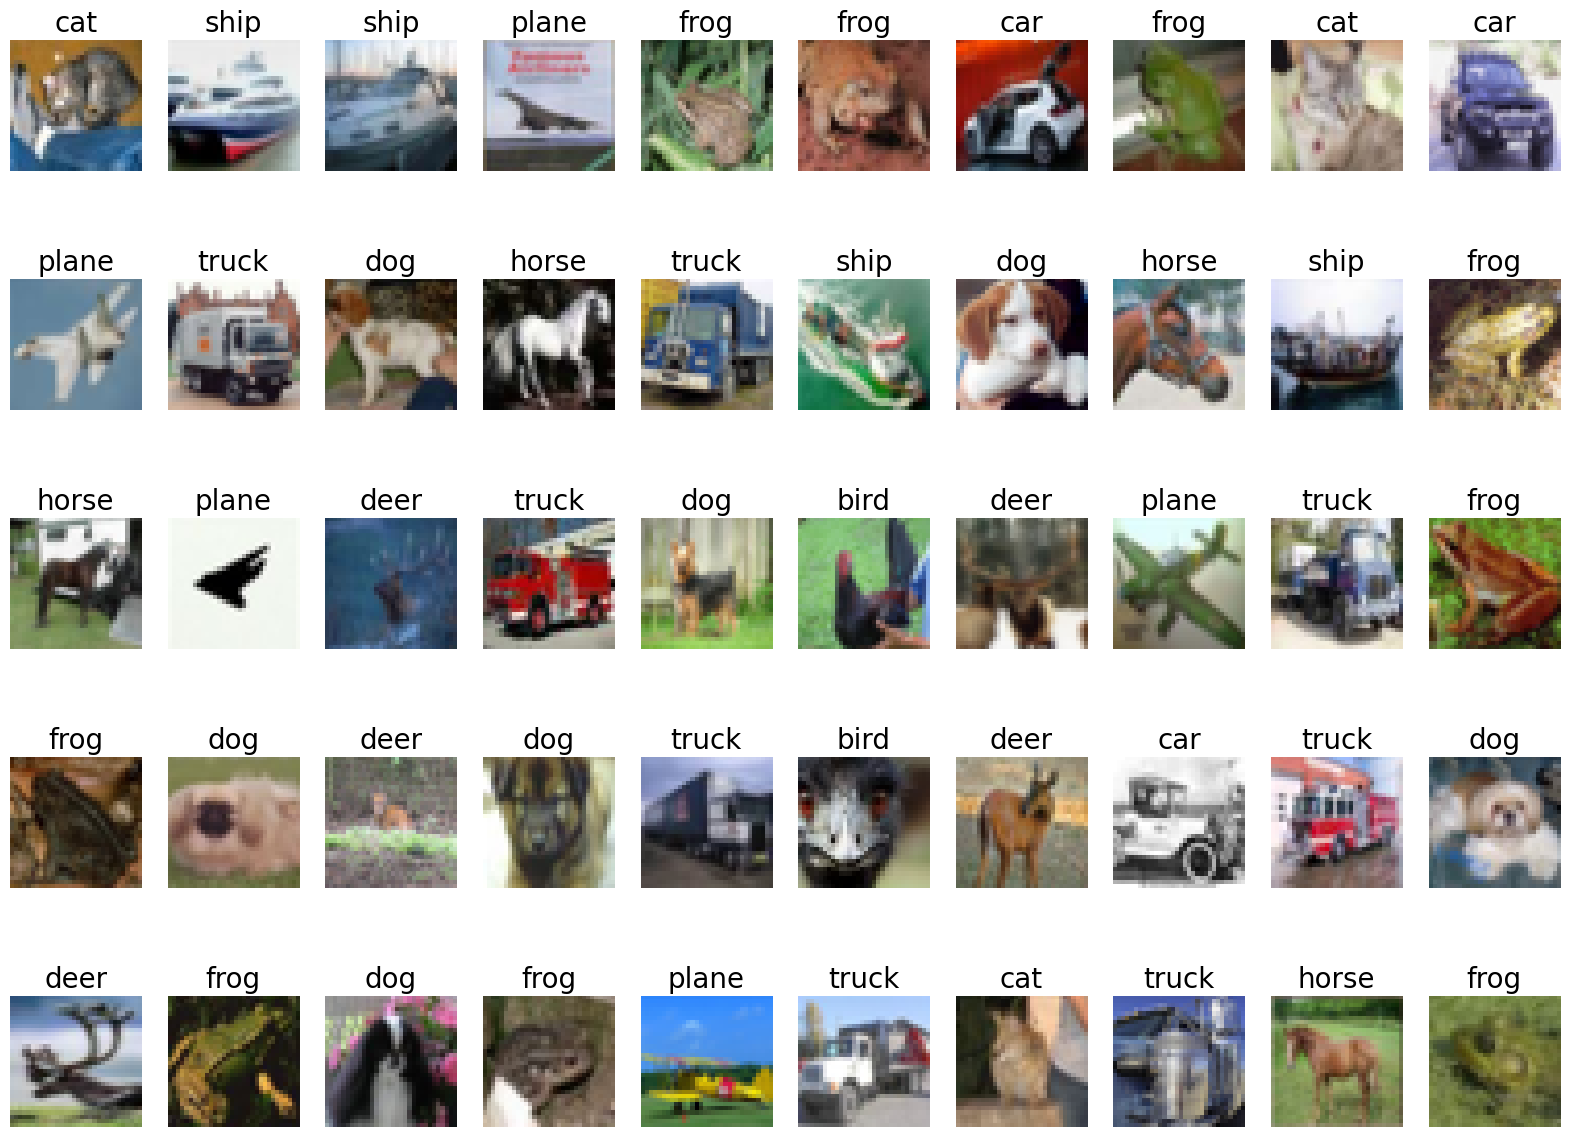

In [34]:
# 検証データのイメージ表示
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
utils.show_images_labels(test_loader2, classes, None, None)

In [35]:
# モデル定義（全結合層）
# 今回は全結合層とCNNの精度を比較する
n_input = 3072  # 32x32x3

n_output = len(classes)

n_hidden = 128

print(f'n_input: {n_input}, n_output: {n_output}, n_hidden: {n_hidden}')

n_input: 3072, n_output: 10, n_hidden: 128


In [36]:
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = Net(n_input, n_output, n_hidden).to(device)

lr = 0.01

optimizer = optim.SGD(net.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

num_epochs = 50

history = np.zeros((0, 5))

utils.torch_seed()

reload(utils)

history = utils.fit(net, optimizer, criterion , num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.94277 acc: 0.32172 val_loss: 1.78735, val_acc: 0.38140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.73247 acc: 0.39598 val_loss: 1.67668, val_acc: 0.41840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.65019 acc: 0.42552 val_loss: 1.61831, val_acc: 0.43680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.59745 acc: 0.44408 val_loss: 1.57725, val_acc: 0.45030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.55793 acc: 0.45766 val_loss: 1.54533, val_acc: 0.46230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.52525 acc: 0.47060 val_loss: 1.52525, val_acc: 0.47120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.49747 acc: 0.48032 val_loss: 1.50710, val_acc: 0.47280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.47328 acc: 0.48932 val_loss: 1.48977, val_acc: 0.48140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.44994 acc: 0.49882 val_loss: 1.47194, val_acc: 0.48750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.42896 acc: 0.50686 val_loss: 1.45975, val_acc: 0.49300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.40869 acc: 0.51390 val_loss: 1.44930, val_acc: 0.49330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.38935 acc: 0.52078 val_loss: 1.43639, val_acc: 0.49660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.37139 acc: 0.52674 val_loss: 1.42713, val_acc: 0.50250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 1.35407 acc: 0.53322 val_loss: 1.41892, val_acc: 0.50410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 1.33697 acc: 0.54060 val_loss: 1.41630, val_acc: 0.50310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 1.32195 acc: 0.54520 val_loss: 1.40399, val_acc: 0.50980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 1.30710 acc: 0.55046 val_loss: 1.40163, val_acc: 0.50760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 1.29286 acc: 0.55696 val_loss: 1.39560, val_acc: 0.51150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 1.27922 acc: 0.55992 val_loss: 1.38722, val_acc: 0.51640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 1.26628 acc: 0.56402 val_loss: 1.38363, val_acc: 0.51280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 1.25368 acc: 0.56928 val_loss: 1.38806, val_acc: 0.51660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 1.24099 acc: 0.57424 val_loss: 1.37672, val_acc: 0.51820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 1.22884 acc: 0.57890 val_loss: 1.37721, val_acc: 0.51610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 1.21728 acc: 0.58266 val_loss: 1.36978, val_acc: 0.52040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 1.20668 acc: 0.58720 val_loss: 1.36795, val_acc: 0.52160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 1.19534 acc: 0.59126 val_loss: 1.36670, val_acc: 0.52470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 1.18432 acc: 0.59498 val_loss: 1.36072, val_acc: 0.52520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 1.17420 acc: 0.59802 val_loss: 1.35885, val_acc: 0.52670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 1.16322 acc: 0.60246 val_loss: 1.35576, val_acc: 0.53040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 1.15337 acc: 0.60548 val_loss: 1.35962, val_acc: 0.52370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 1.14299 acc: 0.61010 val_loss: 1.35623, val_acc: 0.52920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 1.13386 acc: 0.61262 val_loss: 1.35445, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 1.12447 acc: 0.61624 val_loss: 1.35509, val_acc: 0.52290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 1.11485 acc: 0.61946 val_loss: 1.36008, val_acc: 0.52480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 1.10588 acc: 0.62224 val_loss: 1.35168, val_acc: 0.52580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 1.09624 acc: 0.62722 val_loss: 1.35482, val_acc: 0.52370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 1.08697 acc: 0.63006 val_loss: 1.35742, val_acc: 0.52640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 1.07881 acc: 0.63336 val_loss: 1.35478, val_acc: 0.53040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 1.06975 acc: 0.63698 val_loss: 1.35849, val_acc: 0.52750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 1.06025 acc: 0.64082 val_loss: 1.36210, val_acc: 0.52220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 1.05253 acc: 0.64302 val_loss: 1.35848, val_acc: 0.52400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 1.04394 acc: 0.64508 val_loss: 1.36352, val_acc: 0.52440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 1.03472 acc: 0.65022 val_loss: 1.36029, val_acc: 0.52860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 1.02684 acc: 0.65348 val_loss: 1.36010, val_acc: 0.52730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 1.01811 acc: 0.65610 val_loss: 1.36377, val_acc: 0.52710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 1.01111 acc: 0.65846 val_loss: 1.36322, val_acc: 0.52410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 1.00281 acc: 0.66176 val_loss: 1.36747, val_acc: 0.52760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.99458 acc: 0.66550 val_loss: 1.37000, val_acc: 0.52770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.98753 acc: 0.66740 val_loss: 1.36460, val_acc: 0.52900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.97959 acc: 0.67048 val_loss: 1.36781, val_acc: 0.52990


初期状態: 損失: 1.78735 精度: 0.38140
最終状態: 損失: 1.36781 精度: 0.52990


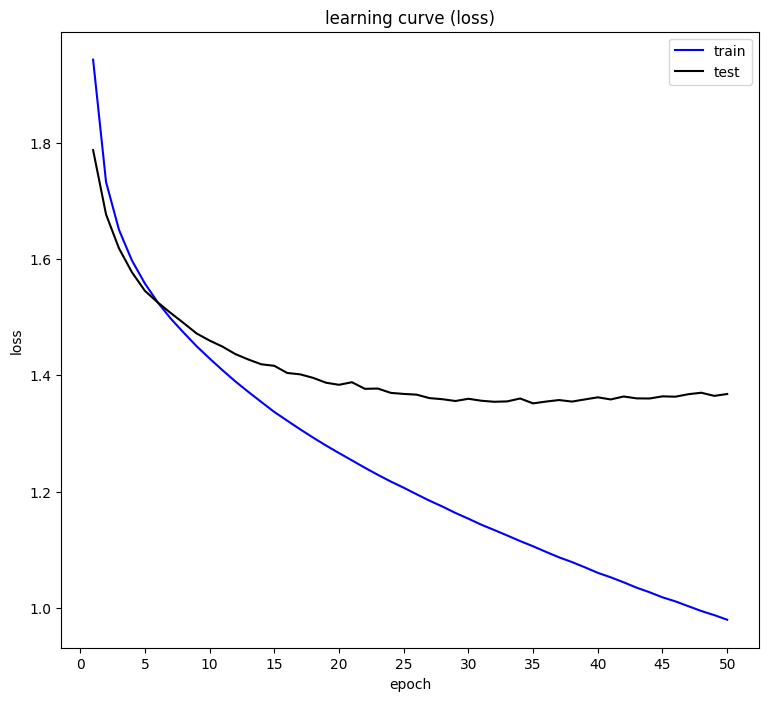

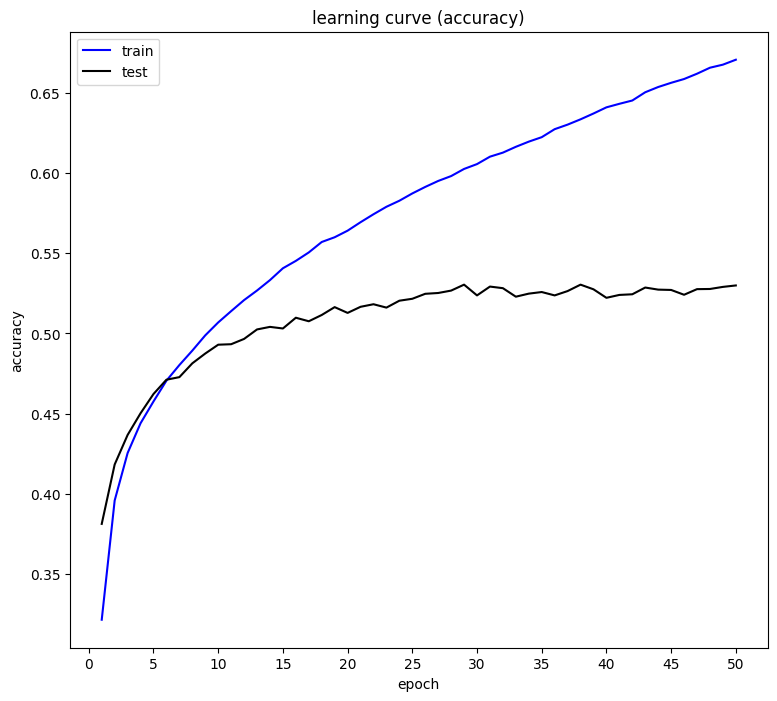

In [38]:
# 精度評価
utils.evaluated_history(history)

In [39]:
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(6272, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        
        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [40]:
print(CNN(n_output, n_hidden))

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [41]:
summary(CNN(n_output, n_hidden), (100, 3, 32, 32), depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Sequential: 1-6                        [100, 10]                 804,234
Total params: 823,626
Trainable params: 823,626
Non-trainable params: 0
Total mult-adds (M): 886.11
Input size (MB): 1.23
Forward/backward pass size (MB): 43.22
Params size (MB): 3.26
Estimated Total Size (MB): 47.71

In [42]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = CNN(n_output, n_hidden).to(device)

lr = 0.01

optimizer = optim.SGD(net.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

num_epochs = 50

history2 = np.zeros((0, 5))

utils.torch_seed()

reload(utils)

history2 = utils.fit(net, optimizer, criterion , num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.11330 acc: 0.24568 val_loss: 1.87133, val_acc: 0.34050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.77537 acc: 0.37434 val_loss: 1.67481, val_acc: 0.40730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.61470 acc: 0.43180 val_loss: 1.52936, val_acc: 0.45790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.48233 acc: 0.47360 val_loss: 1.44705, val_acc: 0.48410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.37758 acc: 0.50926 val_loss: 1.33097, val_acc: 0.52280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.30541 acc: 0.53664 val_loss: 1.29887, val_acc: 0.53610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.25198 acc: 0.55484 val_loss: 1.25195, val_acc: 0.55190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.20178 acc: 0.57420 val_loss: 1.21446, val_acc: 0.56780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.15876 acc: 0.59266 val_loss: 1.18765, val_acc: 0.57620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.11622 acc: 0.60864 val_loss: 1.16770, val_acc: 0.58640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.07428 acc: 0.62220 val_loss: 1.13260, val_acc: 0.60100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.03620 acc: 0.63526 val_loss: 1.10378, val_acc: 0.60860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.99482 acc: 0.65170 val_loss: 1.07631, val_acc: 0.62450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.95808 acc: 0.66430 val_loss: 1.04946, val_acc: 0.63090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.92353 acc: 0.67592 val_loss: 1.04180, val_acc: 0.63880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.88610 acc: 0.69186 val_loss: 1.06387, val_acc: 0.62230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.85330 acc: 0.70172 val_loss: 1.01758, val_acc: 0.64610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.81873 acc: 0.71442 val_loss: 1.02885, val_acc: 0.64070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.78740 acc: 0.72538 val_loss: 1.01602, val_acc: 0.65270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.75434 acc: 0.73588 val_loss: 1.01044, val_acc: 0.64970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.72260 acc: 0.75020 val_loss: 1.03618, val_acc: 0.64710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.69190 acc: 0.76166 val_loss: 1.00291, val_acc: 0.66000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.66181 acc: 0.77254 val_loss: 1.07702, val_acc: 0.63860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.63012 acc: 0.78256 val_loss: 1.04879, val_acc: 0.65560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.59851 acc: 0.79298 val_loss: 1.03889, val_acc: 0.65670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.56894 acc: 0.80538 val_loss: 1.04665, val_acc: 0.66090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.53808 acc: 0.81438 val_loss: 1.05431, val_acc: 0.66230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.50759 acc: 0.82716 val_loss: 1.07604, val_acc: 0.65730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47515 acc: 0.83750 val_loss: 1.15260, val_acc: 0.64340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.44684 acc: 0.84852 val_loss: 1.19185, val_acc: 0.64590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.41880 acc: 0.85786 val_loss: 1.13867, val_acc: 0.65830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.38839 acc: 0.86910 val_loss: 1.16215, val_acc: 0.65870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.36045 acc: 0.87948 val_loss: 1.21956, val_acc: 0.65320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.32736 acc: 0.89130 val_loss: 1.23468, val_acc: 0.65480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.30605 acc: 0.89788 val_loss: 1.31821, val_acc: 0.64780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.27367 acc: 0.91264 val_loss: 1.33838, val_acc: 0.64970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.24869 acc: 0.92016 val_loss: 1.37371, val_acc: 0.65640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.22045 acc: 0.93178 val_loss: 1.41247, val_acc: 0.65210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.20170 acc: 0.93800 val_loss: 1.44349, val_acc: 0.65250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.18001 acc: 0.94608 val_loss: 1.51077, val_acc: 0.64700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.15442 acc: 0.95566 val_loss: 1.56677, val_acc: 0.64350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.12956 acc: 0.96604 val_loss: 1.59316, val_acc: 0.65210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.11315 acc: 0.97172 val_loss: 1.66876, val_acc: 0.64790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.10091 acc: 0.97406 val_loss: 1.71907, val_acc: 0.64680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.07438 acc: 0.98506 val_loss: 1.78633, val_acc: 0.64820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.06297 acc: 0.98910 val_loss: 1.81984, val_acc: 0.64980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.04865 acc: 0.99260 val_loss: 1.87374, val_acc: 0.65030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.03579 acc: 0.99704 val_loss: 1.92844, val_acc: 0.64780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.02767 acc: 0.99826 val_loss: 1.98121, val_acc: 0.65020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.02232 acc: 0.99898 val_loss: 2.03166, val_acc: 0.64940


初期状態: 損失: 1.87133 精度: 0.34050
最終状態: 損失: 2.03166 精度: 0.64940


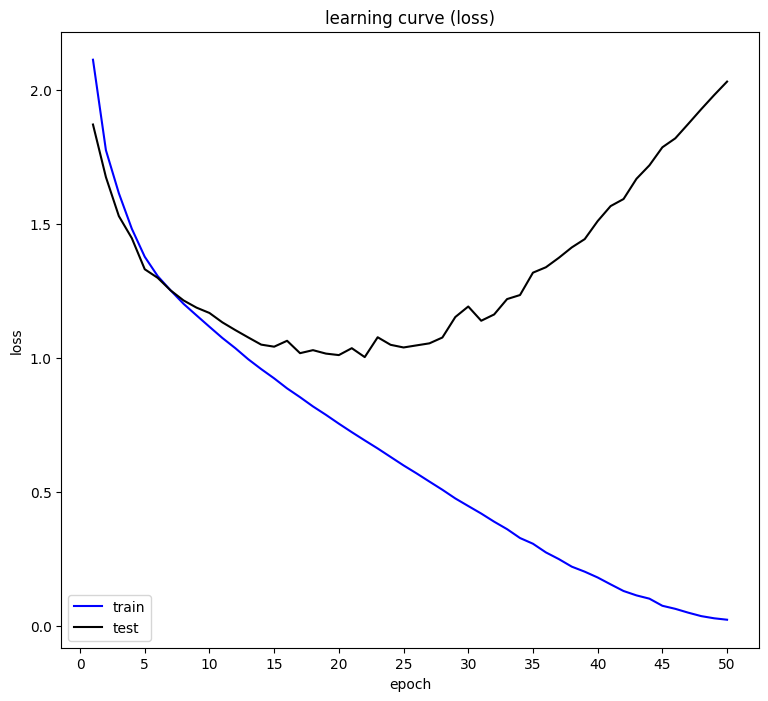

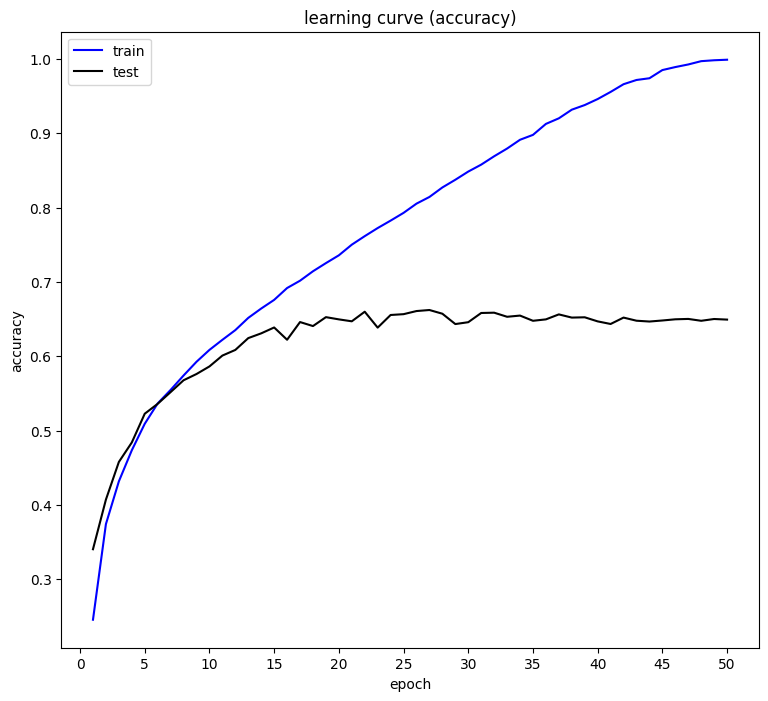

In [43]:
# 精度評価
utils.evaluated_history(history2)

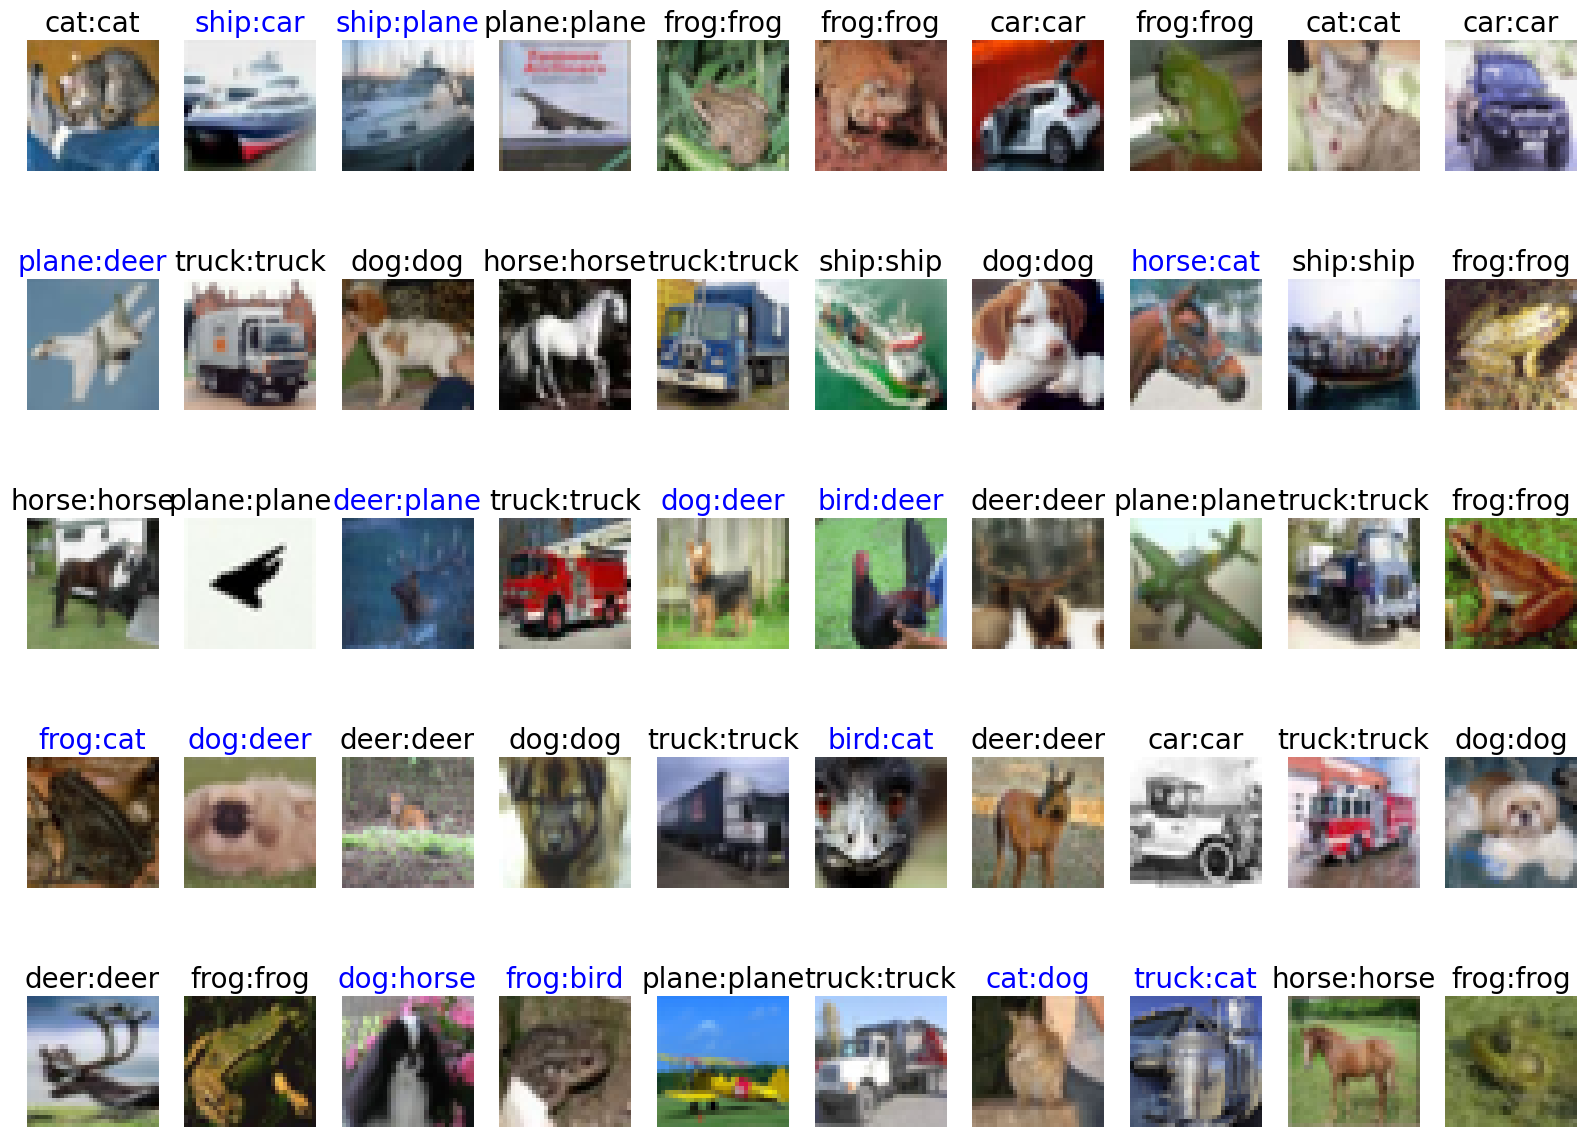

In [44]:
# 最初の50毎の画像の結果表示
utils.show_images_labels(test_loader2, classes, net, device)